## Composite Bayesian Optimization with Multi-Task Gaussian Processes

In this tutorial, we'll be describing how to perform multi-task Bayesian optimization over composite functions. In these types of problems, there are several related outputs, and an overall easy to evaluate objective function that we wish to maximize.

**Multi-task Bayesian Optimization** was first proposed by [Swersky et al, NeurIPS, '13](https://papers.neurips.cc/paper/2013/hash/f33ba15effa5c10e873bf3842afb46a6-Abstract.html) in the context of fast hyper-parameter tuning for neural network models; however, we demonstrate a more advanced use-case of **[composite Bayesian optimization](https://proceedings.mlr.press/v97/astudillo19a.html)** where the overall function that we wish to optimize is a cheap-to-evaluate (and known) function of the outputs. In general, we expect that using more information about the function should yield improved performance when attempting to optimize it, particularly if the metric function itself is quickly varying.

See [the composite BO tutorial w/ HOGP](https://github.com/pytorch/botorch/blob/main/tutorials/composite_bo_with_hogp.ipynb) for a more technical introduction. In general, we suggest using MTGPs for unstructured task outputs and the HOGP for matrix / tensor structured outputs.


We will use a Multi-Task Gaussian process ([MTGP](https://papers.nips.cc/paper/2007/hash/66368270ffd51418ec58bd793f2d9b1b-Abstract.html)) with an ICM kernel to model all of the outputs in this problem. MTGPs can be easily accessed in Botorch via the `botorch.models.KroneckerMultiTaskGP` model class (for the "block design" case of fully observed outputs at all inputs). Given $T$ tasks (outputs) and $n$ data points, they assume that the responses, $Y \sim \mathbb{R}^{n \times T},$ are distributed as $\text{vec}(Y) \sim \mathcal{N}(f, D)$ and $f \sim \mathcal{GP}(\mu_{\theta}, K_{XX} \otimes K_{T}),$ where $D$ is a (diagonal) noise term.

In [1]:
import os
import time

import torch
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition.objective import GenericMCObjective
from botorch.models import KroneckerMultiTaskGP, SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.sampling.normal import IIDNormalSampler

from botorch.test_functions import Hartmann
from gpytorch.mlls import ExactMarginalLogLikelihood

import warnings
warnings.filterwarnings("ignore")

SMOKE_TEST = os.environ.get("SMOKE_TEST")

I0315 191509.128 _utils_internal.py:179] NCCL_DEBUG env var is set to None


I0315 191509.131 _utils_internal.py:188] NCCL_DEBUG is INFO from /etc/nccl.conf


### Set device, dtype and random seed

In [2]:
torch.random.manual_seed(10)

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

### Problem Definition

The function that we wish to optimize is based off of a contextual version of the Hartmann-6 test function, where following [Feng et al, NeurIPS, '20](https://proceedings.neurips.cc/paper/2020/hash/faff959d885ec0ecf70741a846c34d1d-Abstract.html) we convert the sixth task dimension into a task indicator. Here we assume that we evaluate all contexts at once.

In [3]:
from botorch.test_functions import Hartmann
from torch import Tensor


class ContextualHartmann6(Hartmann):
    def __init__(self, num_tasks: int = 20, noise_std=None, negate=False):
        super().__init__(dim=6, noise_std=noise_std, negate=negate)
        self.task_range = torch.linspace(0, 1, num_tasks).unsqueeze(-1)
        self._bounds = [(0.0, 1.0) for _ in range(self.dim - 1)]
        self.bounds = torch.tensor(self._bounds).t()

    def evaluate_true(self, X: Tensor) -> Tensor:
        batch_X = X.unsqueeze(-2)
        batch_dims = X.ndim - 1

        expanded_task_range = self.task_range
        for _ in range(batch_dims):
            expanded_task_range = expanded_task_range.unsqueeze(0)
        task_range = expanded_task_range.repeat(*X.shape[:-1], 1, 1).to(X)
        concatenated_X = torch.cat(
            (
                batch_X.repeat(*[1] * batch_dims, self.task_range.shape[0], 1),
                task_range,
            ),
            dim=-1,
        )
        return super().evaluate_true(concatenated_X)

We use `GenericMCObjective` to define the differentiable function that we are optimizing. Here, it is defined as 
$$g(f) = \sum_{i=1}^T \cos(f_i^2 + f_i w_i)$$
where $w$ is a weight vector (drawn randomly once at the start of the optimization). As this function is a non-linear function of the outputs $f,$ we cannot compute acquisition functions via computation of the posterior mean and variance, but rather have to compute posterior samples and evaluate acquisitions with Monte Carlo sampling. 

For greater than $10$ or so tasks, it is computationally challenging to sample the posterior over all tasks jointly using conventional approaches, except that [Maddox et al, '21](https://arxiv.org/abs/2106.12997) have devised an efficient method for exploiting the structure in the posterior distribution of the MTGP, enabling efficient MC based optimization of objectives using MTGPs. In this tutorial, we choose 6  contexts/tasks for demostration. 

In [4]:
num_tasks = 6
problem = ContextualHartmann6(num_tasks= num_tasks, noise_std=0.001, negate=True).to(**tkwargs)

# we choose num_tasks random weights
weights = torch.randn(num_tasks, **tkwargs)


def callable_func(samples, X=None):
    res = -torch.cos((samples**2) + samples * weights)
    return res.sum(dim=-1)


objective = GenericMCObjective(callable_func)

In [5]:
bounds = problem.bounds

### Define helper functions

Define helper functions used for optimizing the acquisition function and for constructing the batch expected improvement acquisition, which we optimize for both the batch GP and MTGP.

In [6]:
def optimize_acqf_and_get_candidate(acq_func, bounds, batch_size):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=batch_size,
        num_restarts=10,
        raw_samples=512,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200, "init_batch_limit": 5},
    )
    # observe new values
    new_x = candidates.detach()
    return new_x

In [7]:
def construct_acqf(model, objective, num_samples, best_f):
    sampler = IIDNormalSampler(sample_shape=torch.Size([num_samples]))
    qEI = qExpectedImprovement(
        model=model,
        best_f=best_f,
        sampler=sampler,
        objective=objective,
    )
    return qEI

Set environmental parameters, we use 20 initial data points and optimize for 20 steps with a batch size of 3 candidate points at each evaluation.

In [8]:
if SMOKE_TEST:
    n_init = 5
    n_steps = 1
    batch_size = 2
    num_samples = 4
    n_trials = 2
    verbose = False
else:
    n_init = 10
    n_steps = 10
    batch_size = 3
    num_samples = 64
    n_trials = 3
    verbose = True

## BO Loop

Warning... this optimization loop can take a while, especially on the CPU. We compare to both random sampling and a batch GP fit in a composite manner on every output. The batch GP does not take into account any correlations between the different tasks.

In [9]:
from botorch.optim.fit import fit_gpytorch_mll_torch
from torch.optim.adam import Adam
from functools import partial

In [10]:
mtgp_trial_objectives = []
batch_trial_objectives = []
batch_trial_objectives_legacy = []

rand_trial_objectives = []

for trial in range(n_trials):
    init_x = (bounds[1] - bounds[0]) * torch.rand(
        n_init, bounds.shape[1], **tkwargs
    ) + bounds[0]

    init_y = problem(init_x)

    mtgp_train_x, mtgp_train_y = init_x, init_y
    batch_train_x, batch_train_y = init_x, init_y
    rand_x, rand_y = init_x, init_y

    best_value_mtgp = objective(init_y).max()
    best_value_batch = best_value_mtgp
    best_random = best_value_mtgp
    
    optimizer = partial(Adam, lr=0.01)

    for iteration in range(n_steps):
        # we empty the cache to clear memory out
        torch.cuda.empty_cache()

        # MTGP
        mtgp_t0 = time.monotonic()
        mtgp = KroneckerMultiTaskGP(
            mtgp_train_x,
            mtgp_train_y,
        )
        mtgp_mll = ExactMarginalLogLikelihood(mtgp.likelihood, mtgp)
        fit_gpytorch_mll_torch(
            mtgp_mll,
            optimizer=optimizer,
            step_limit=3000,
        )

        mtgp_acqf = construct_acqf(mtgp, objective, num_samples, best_value_mtgp)
        new_mtgp_x = optimize_acqf_and_get_candidate(mtgp_acqf, bounds, batch_size)
        mtgp_train_x = torch.cat((mtgp_train_x, new_mtgp_x), dim=0)
        mtgp_train_y = torch.cat((mtgp_train_y, problem(new_mtgp_x)), dim=0)
        best_value_mtgp = objective(mtgp_train_y).max()
        mtgp_t1 = time.monotonic()

        # Batch
        batch_t0 = time.monotonic()
        batchgp = SingleTaskGP(
            batch_train_x,
            batch_train_y,
        )
        batch_mll = ExactMarginalLogLikelihood(batchgp.likelihood, batchgp)
        fit_gpytorch_mll_torch(
            batch_mll,
            optimizer=optimizer,
            step_limit=3000,
        )
        batch_acqf = construct_acqf(batchgp, objective, num_samples, best_value_batch)
        new_batch_x = optimize_acqf_and_get_candidate(batch_acqf, bounds, batch_size)
        batch_train_x = torch.cat((batch_train_x, new_batch_x), dim=0)
        batch_train_y = torch.cat((batch_train_y, problem(new_batch_x)), dim=0)
        best_value_batch = objective(batch_train_y).max()
        
        batch_t1 = time.monotonic()

        # rand
        new_rand_x = (bounds[1] - bounds[0]) * torch.rand(
            batch_size, bounds.shape[1], **tkwargs
        ) + bounds[0]
        rand_x = torch.cat((rand_x, new_rand_x))
        rand_y = torch.cat((rand_y, problem(new_rand_x)))
        best_random = objective(rand_y).max()

        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, mtgp, batch) = "
                f"({best_random:>4.2f}, {best_value_mtgp:>4.2f}, {best_value_batch:>4.2f}), "
                f"batch time = {batch_t1-batch_t0:>4.2f}, mtgp time = {mtgp_t1-mtgp_t0:>4.2f}",
                end="",
            )
        else:
            print(".", end="")

    mtgp_trial_objectives.append(objective(mtgp_train_y).detach().cpu())
    batch_trial_objectives.append(objective(batch_train_y).detach().cpu())
    rand_trial_objectives.append(objective(rand_y).detach().cpu())


Batch  0: best_value (random, mtgp, batch) = (-4.97, -3.40, -3.79), batch time = 1.91, mtgp time = 11.93
Batch  1: best_value (random, mtgp, batch) = (-4.97, -3.40, -3.33), batch time = 3.35, mtgp time = 9.48
Batch  2: best_value (random, mtgp, batch) = (-4.22, -3.37, -3.33), batch time = 3.05, mtgp time = 13.88
Batch  3: best_value (random, mtgp, batch) = (-4.22, -3.37, -2.86), batch time = 2.40, mtgp time = 24.61
Batch  4: best_value (random, mtgp, batch) = (-4.22, -3.36, -2.77), batch time = 3.23, mtgp time = 20.29
Batch  5: best_value (random, mtgp, batch) = (-3.50, -3.36, -2.77), batch time = 3.20, mtgp time = 16.19
Batch  6: best_value (random, mtgp, batch) = (-3.50, -0.96, -2.70), batch time = 3.47, mtgp time = 32.38
Batch  7: best_value (random, mtgp, batch) = (-3.50, -0.88, -0.61), batch time = 3.24, mtgp time = 20.44
Batch  8: best_value (random, mtgp, batch) = (-2.58, -0.88, 0.35), batch time = 2.72, mtgp time = 36.22
Batch  9: best_value (random, mtgp, batch) = (-2.58, -0.

### Plot Results

In [11]:
import matplotlib.pyplot as plt

Finally, we plot the results, where we see that the MTGP tends to outperform both the batch GP and the random baseline. The optimization procedure seems to have a good deal less noise than the batch GP.

However, as demonstrated above, optimizing the acquisition function and fitting the MTGP tend to take a bit longer.

In [12]:
mtgp_results = torch.stack(mtgp_trial_objectives)[:, n_init:].cummax(1).values
batch_results = torch.stack(batch_trial_objectives)[:, n_init:].cummax(1).values
random_results = torch.stack(rand_trial_objectives)[:, n_init:].cummax(1).values

Text(0, 0.5, 'Best Objective Achieved')

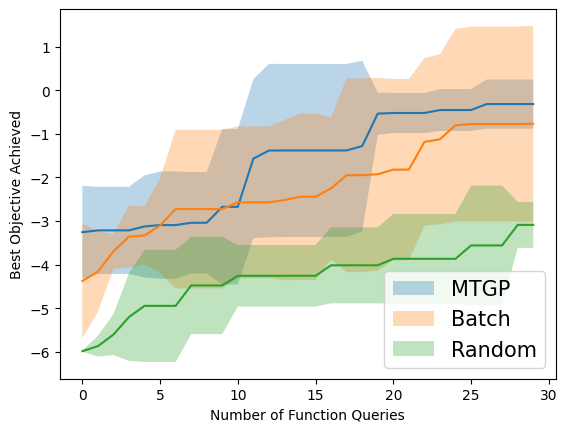

In [13]:
plt.plot(mtgp_results.mean(0))
plt.fill_between(
    torch.arange(n_steps * batch_size),
    mtgp_results.mean(0) - 2.0 * mtgp_results.std(0) / (n_trials**0.5),
    mtgp_results.mean(0) + 2.0 * mtgp_results.std(0) / (n_trials**0.5),
    alpha=0.3,
    label="MTGP",
)

plt.plot(batch_results.mean(0))
plt.fill_between(
    torch.arange(n_steps * batch_size),
    batch_results.mean(0) - 2.0 * batch_results.std(0) / (n_trials**0.5),
    batch_results.mean(0) + 2.0 * batch_results.std(0) / (n_trials**0.5),
    alpha=0.3,
    label="Batch",
)

plt.plot(random_results.mean(0))
plt.fill_between(
    torch.arange(n_steps * batch_size),
    random_results.mean(0) - 2.0 * random_results.std(0) / (n_trials**0.5),
    random_results.mean(0) + 2.0 * random_results.std(0) / (n_trials**0.5),
    alpha=0.3,
    label="Random",
)

plt.legend(loc="lower right", fontsize=15)
plt.xlabel("Number of Function Queries")
plt.ylabel("Best Objective Achieved")

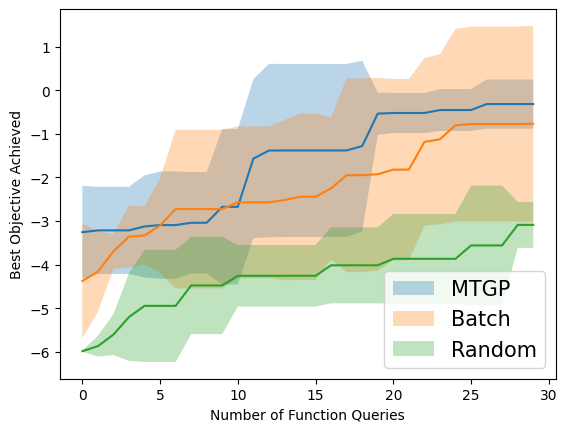

In [14]:
plt.plot(mtgp_results.mean(0))
plt.fill_between(
    torch.arange(n_steps * batch_size),
    mtgp_results.mean(0) - 2.0 * mtgp_results.std(0) / (n_trials**0.5),
    mtgp_results.mean(0) + 2.0 * mtgp_results.std(0) / (n_trials**0.5),
    alpha=0.3,
    label="MTGP",
)

plt.plot(batch_results.mean(0))
plt.fill_between(
    torch.arange(n_steps * batch_size),
    batch_results.mean(0) - 2.0 * batch_results.std(0) / (n_trials**0.5),
    batch_results.mean(0) + 2.0 * batch_results.std(0) / (n_trials**0.5),
    alpha=0.3,
    label="Batch",
)

plt.plot(random_results.mean(0))
plt.fill_between(
    torch.arange(n_steps * batch_size),
    random_results.mean(0) - 2.0 * random_results.std(0) / (n_trials**0.5),
    random_results.mean(0) + 2.0 * random_results.std(0) / (n_trials**0.5),
    alpha=0.3,
    label="Random",
)

plt.legend(loc="lower right", fontsize=15)
plt.xlabel("Number of Function Queries")
plt.ylabel("Best Objective Achieved")
plt.show()